Notebook to create a regional rainfall-runoff model using a hybrid approach (LSTM+NonSense). The LSTM gives a dynamic parameterization of the hydrological model

In [1]:
#Import necessary packages
import os
import pandas as pd
import numpy as np
import itertools
import random
import time
import datetime
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import BatchSampler

In [2]:
# identify and define GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
# set cuda0 as GPU
cuda0 = torch.device('cuda:0')

1
NVIDIA GeForce GTX 1050 Ti with Max-Q Design


In [3]:
# colorblind friendly color palet
color_dictionary = {
    "Observed": "#7b85d4",
    "LSTM": "#e9d043",
    "LSTM+SHM": "#83c995",
    "LSTM+Bucket": "#859795",
    "LSTM+NonSense": "#ad5b50",
    "SHM": "#f37738"}

Part 1. Classes and functions

In [4]:
class SequenceData(Dataset):
    """
    This class will allow us to create a custom DataSet to handle time series of the different basins. 

    Objective:
    The major objective of the class is to create two tensors.
    1) The first tensor will be a 3D tensor that contains the information of a specific basins. The 3D tensor
    will be a concatenation of 2D tensors (one 2D tensor per basin) along the third axis. For each 2D tensor, the rows
    are the time (one row per day) and the columns are the features (forcing variables and static attributes).
    2) The second tensor will have the same structure as the one described before, but it just have one column, that is
    associated with the target variable.
    """
    #Function to initialize the data
    def __init__(self,
                 gauges_id,  # ID of basins [list]
                 forcing,  # name of the dynamic forcings [list]
                 target,  # name of the target [list]
                 attributes,  # name of the static attributes [list]
                 sequence_length,  # sequence length in days for the lstm [integer]
                 time_period,  # start and end day of training period [list]
                 path_ts,  # path to time series [string]
                 path_climatic_attributes,  # path to climatic attributes[string]
                 path_hydrologic_attributes,  # path to hydrologic attributes [string]
                 path_topographic_attributes,  # path to topographic attributes [string]
                 path_landcover_attributes,  # path to landcover attributes [string]
                 path_soil_attributes  # path to landcover attributes [string]
                 ):

        # read variables and store them in self
        self.time_period = time_period
        self.catch_ids = gauges_id  # catchment ID
        self.forcing = forcing  # dynamic attributes
        self.target = target  # target
        self.attributes = attributes  # static attributes
        self.sequence_length = sequence_length  # sequence length

        self.path_climatic_attributes = path_climatic_attributes
        self.path_hydrologic_attributes = path_hydrologic_attributes
        self.path_topographic_attributes = path_topographic_attributes
        self.path_landcover_attributes = path_landcover_attributes
        self.path_soil_attributes = path_soil_attributes

        # process the attributes
        self.df_attributes = self.process_attributes()

        # Initialize the vectors that will be later used to standardize all the inputs)
        self.global_forcing_means = torch.zeros((1, len(self.forcing) - 1 + len(self.attributes)), dtype=torch.float32)
        self.global_forcing_stds = torch.ones((1, len(self.forcing) - 1 + len(self.attributes)), dtype=torch.float32)

        # this loop goes through all the catchments, and concatenate along a third dimension the time series of each
        # catchment. At the end I will have a 3D tensor, where the 1st dimension (rows) are days, the second (columns)
        # are features, and the third are basins.
        for i, catch_id in enumerate(self.catch_ids):
            # the time series path change from basin to basin
            path_timeseries = path_ts + 'CAMELS_GB_hydromet_timeseries_' + str(catch_id) + '.csv'

            # load time series
            df_ts = pd.read_csv(path_timeseries)

            # load dynamic forcings
            df_forcing = df_ts.loc[:, self.forcing]
            df_forcing = df_forcing.set_index('date')

            # load target value
            df_target = df_ts.loc[:, self.target]
            df_target = df_target.set_index('date')

            # read training subset
            df_forcing = df_forcing.loc[self.time_period[0]:self.time_period[1]]
            df_target = df_target.loc[self.time_period[0]:self.time_period[1]]

            # filter the attributes for the specific catchment
            df_attributes = self.df_attributes[self.df_attributes.index == catch_id]
            # repeat the static attributes to the length of the timeseries
            ob_df_attri = pd.DataFrame(np.repeat(df_attributes.values, len(df_forcing), axis=0))
            ob_df_attri.columns = df_attributes.columns
            ob_df_attri.index = df_forcing.index

            # join dynamic forcings and static attributes-
            df_all = df_forcing.join(ob_df_attri)

            # concatenate this basin time series with the tensor that contains all the time series. if i=0 there is
            # nothing to concatenate with, so we just create the vector, in the else case we do concatenate.
            if i == 0:
                # select features (X) and target (y)
                self.X = torch.tensor(df_all.values, dtype=torch.float32).unsqueeze(2)
                self.y = torch.tensor(df_target.values, dtype=torch.float32).unsqueeze(2)

            else:
                # select features (X) and target (y)
                X = torch.tensor(df_all.values, dtype=torch.float32).unsqueeze(2)
                y = torch.tensor(df_target.values, dtype=torch.float32).unsqueeze(2)

                self.X = torch.cat((self.X, X), dim=2)
                self.y = torch.cat((self.y, y), dim=2)

    def __len__(self):
        # Function to define length of data (same as length of my time series)
        return self.X.shape[0]

    def __getitem__(self, id):
        # Function to extract the necessary information during training, validation and testing
        basin = id[0] #basin of interest
        days = id[1]  # days I want to extract

        # Extract the information going as input to the LSTM
        X_LSTM = torch.empty(size=(len(days), self.sequence_length, self.X.size()[1]))
        for i, day in enumerate(days):
            i_start = day - self.sequence_length + 1
            temp = self.X[i_start:(day + 1),:, basin]
            temp = (temp - self.global_forcing_means) / self.global_forcing_stds
            X_LSTM[i, :, :] = temp

        # Extract information going as input to the conceptual model
        X_SHM = self.X[days, 0:3, basin]
        # Extract target information
        y_obs = self.y[days, :, basin]

        return X_LSTM, X_SHM, y_obs

    def process_attributes(self):
        # Function to process the attributes and return the ones we are interested in
        df_climatic_attributes = pd.read_csv(self.path_climatic_attributes).set_index('gauge_id')
        df_hydrologic_attributes = pd.read_csv(self.path_hydrologic_attributes).set_index('gauge_id')
        df_topographic_attributes = pd.read_csv(self.path_topographic_attributes).set_index('gauge_id')
        df_landcover_attributes = pd.read_csv(self.path_landcover_attributes).set_index('gauge_id')
        df_soil_attributes = pd.read_csv(self.path_soil_attributes).set_index('gauge_id')
        # join attributes
        df_attributes = (((df_climatic_attributes.join(
            df_hydrologic_attributes)).join(
            df_topographic_attributes)).join(
            df_landcover_attributes)).join(
            df_soil_attributes)
        # filter attributes by catchment
        df_attributes = df_attributes[df_attributes.index.isin(self.catch_ids)]
        # filter attributes by name
        df_attributes = df_attributes[self.attributes]

        return df_attributes

    def global_statistics(self):
        # Split it along the column dimension
        splits = torch.split(self.X, split_size_or_sections=1, dim=1)

        # Initialize the mean and std vectors
        dynamic_forcing_means = torch.empty((1,self.X.size()[1]), dtype=torch.float32)
        dynamic_forcing_stds = torch.empty((1,self.X.size()[1]), dtype=torch.float32)

        # Calculate the mean and std of each dynamic forcing
        for i, split in enumerate(splits):
            dynamic_forcing_means[0, i] = split.mean()
            dynamic_forcing_stds[0, i] = split.std()

        self.global_forcing_means = dynamic_forcing_means
        self.global_forcing_stds = dynamic_forcing_stds

In [5]:
'''
Class to run the hydrological model with dynamic parameterization. The forward method will recieves the output
of the LSTM network and map those to values inside predefined ranges. Then those values will be used 
as parameters of the hydrological model.
'''
class SHM_dynamic_parameters(nn.Module):
    def __init__(self):
        # Initiate a SHM instance
        super(SHM_dynamic_parameters, self).__init__()
    
    def forward(self, X_SHM, out_LSTM, initial_states, cuda):
        # ranges in which my parameters can vary 
        param_ranges = torch.tensor([[0.0,10], #dd
                                     [20,700], #sumax
                                     [1.0, 6.0], #beta
                                     [1.0, 100.0], #ki
                                     [10.0, 1000.0 ]],#kb
                                     dtype=torch.float32)
        
        # use output of LSTM (between 0 and 1 due to a sigmoid) to produce dynamic parameters
        dd = param_ranges[0][0] + out_LSTM[:,0]*(param_ranges[0][1]-param_ranges[0][0])
        sumax = param_ranges[1][0] + out_LSTM[:,1]*(param_ranges[1][1]-param_ranges[1][0])
        beta = param_ranges[2][0] + out_LSTM[:,2]*(param_ranges[2][1]-param_ranges[2][0])
        ki = param_ranges[3][0] + out_LSTM[:,3]*(param_ranges[3][1]-param_ranges[3][0])
        kb = param_ranges[4][0] + out_LSTM[:,4]*(param_ranges[4][1]-param_ranges[4][0])

        # read initial states
        ss, su, si, sb = initial_states

        # initialize vector
        q_out = torch.zeros((X_SHM.shape[0], 1)).to(cuda)
        states = torch.zeros((X_SHM.shape[0], initial_states.shape[0])).to(cuda)

        #run SHM model
        for j, (p, pet, temp) in enumerate(X_SHM):
            
            # Snow module --------------------------
            if temp > 0: # if there is snowmelt
                qs_out = torch.min(ss, dd[j]*temp) # snowmelt from snow reservoir
                ss = ss - qs_out # substract snowmelt from snow reservoir
                qsp_out = qs_out + p # flow from snowmelt and rainfall
            else: # if the is no snowmelt
                ss=ss + p # precipitation accumalates as snow in snow reservoir
                qsp_out = torch.tensor(0.0, dtype=torch.float32).to(cuda)
            
            # Baseflow reservoir -------------------
            sb = sb + qsp_out #[mm]
            qb_out = sb / kb[j] #[mm]
            sb = sb - qb_out #[mm]
            
            # Interflow reservoir ------------------
            si = si + qb_out #[mm]
            qi_out = si / ki[j] #[mm]
            si = si - qi_out #[mm]

            
            # Unsaturated zone----------------------
            psi = (su / sumax[j]) ** beta[j] #[-]
            su_temp = su + qi_out  * (1 - psi)
            su = torch.minimum(su_temp, sumax[j])
            qu_out = qi_out * psi + torch.maximum(torch.tensor(0.0, dtype=torch.float32).to(cuda), su_temp - sumax[j]) # [mm]
            
            # Evapotranspiration -------------------
            klu = torch.tensor(0.90, requires_grad=False, dtype=torch.float32).to(cuda) # land use correction factor [-]
            if su <= 0.0:
                ktetha = torch.tensor(0.0, requires_grad=False, dtype=torch.float32).to(cuda)
            elif su >= 0.8 * sumax[j]:
                ktetha = torch.tensor(1.0, requires_grad=False, dtype=torch.float32).to(cuda)
            else:
                ktetha = su / sumax[j]

            ret = pet * klu * ktetha #[mm]
            su = torch.maximum(torch.tensor(0.0, requires_grad=True, dtype=torch.float32), su - ret) #[mm]
            
            # states
            states[j,:] = torch.cat((ss.unsqueeze(0), su.unsqueeze(0), si.unsqueeze(0), sb.unsqueeze(0)))
            # Output
            q_out[j,0] = qu_out #[mm]

        # concatenate dynamic parameters
        dyn_parameters = torch.stack((dd, sumax, beta, ki, kb),dim=1)

        return q_out, dyn_parameters, states

In [6]:
# Class to create the hybrid model. Here is where I combine the LSTM network with the hydrological model
class Hybrid_Model(nn.Module):
    def __init__(self, network_params, cuda):
        super().__init__()

        self.num_features = network_params['input_size']
        self.hidden_units = network_params['hidden_size']
        self.num_layers = network_params['no_of_layers']
        self.cuda0 = cuda

        # Create LSTM network
        self.lstm = nn.LSTM(input_size = network_params['input_size'], 
                            hidden_size = network_params['hidden_size'], 
                            batch_first = True,
                            num_layers = network_params['no_of_layers'])

        
        self.dropout = torch.nn.Dropout(network_params['drop_out'])
        #out_features should be changed depending on the number of parameters!!!
        self.linear = nn.Linear(in_features=network_params['hidden_size'], out_features=5)
        # Create hydrological model
        self.SHM = SHM_dynamic_parameters()
           
    def forward(self, X_LSTM, X_SHM, initial_states, warmup_period=0):
        
        # Initialize hidden state with zeros
        batch_size = X_LSTM.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.cuda0)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.cuda0)
        
        # run LSTM: The LSTM predicts the values that will be used by the hydrological model as parameters. 
        # It predicts the all the timesteps at once! This means that if I am running by hydrological model 
        # for 2 years, the LSTM will predict the values of all the parameters for the 2 years at once. 
        out, (hn_1, cn_1) = self.lstm(X_LSTM, (h0, c0))
        out = out[:,-1,:] # many to one / sequence to one
        out = self.dropout(out)
        out = self.linear(out)
        out = torch.sigmoid(out)

        # warmup period to stabilize the interna states (buckets) of the hydrological model
        if warmup_period>0:
            with torch.no_grad():
                _, _, states = self.SHM(X_SHM = X_SHM[0:warmup_period,:], 
                                        out_LSTM = out[0:warmup_period,:], 
                                        initial_states = initial_states,
                                        cuda = self.cuda0)
                
                initial_states = states[-1,:]
                
        # run the model
        q_out, parameters, states = self.SHM(X_SHM = X_SHM[warmup_period:,:], 
                                        out_LSTM = out[warmup_period:,:], 
                                        initial_states = initial_states,
                                        cuda = self.cuda0)
                
        return q_out, parameters, states

In [7]:
'''
During the optimization I will use batches of 2 years of data, one for warmup and another for
optimization. This class is used so the DataLoader (pytorch class) can extract the information in
that way. It will create all the posible combinations of basins + 2 year period.

Example: 
1) If we have 4 years of data and 2 basins
2) We have three 2-year windows: [[y1,y2], [y2,y3], [y3,y4]], where yi is the index of the ~365 days
of each year.
3) We then combine this with each basin (lets call them B1 and B2)

Final output: [[B1, [y1,y2]], [B1, [y2,y3]], [B1, [y3,y4]], [B2, [y1,y2]], [B2, [y2,y3]], [B2, [y3,y4]]]

This is send by the DataLoader to the _getitem_ function of the Dataset class to retrieve the
necessary information. 
'''
class BasinSampler_Training(BatchSampler):
    def __init__(self,
                 basins_list,  # list with all the basins
                 year_batches,  # list of lists with year periods
                 suffle=True):
        
        self.basins_list = basins_list
        self.year_batches = year_batches
        self.suffle=suffle

    def __iter__(self):
        # Vector of basins
        aux1 = self.basins_list
        if self.suffle:
            random.shuffle(aux1)

        # Groups two consequtive years, one for warmup period and the other for training
        time_batches = [self.year_batches[i] + self.year_batches[i + 1] for i in range(len(self.year_batches) - 1)]
        if self.suffle:
            random.shuffle(time_batches)

        # Creates the final batches (list of lists), that is a combination of the basins_batches and days_batches
        combinations = list(itertools.product(aux1, time_batches))
        if self.suffle:
            random.shuffle(combinations)

        # Deliver the combinations one by one to the DataLoader.
        for combination in combinations:
            yield combination

    def __len__(self) -> int:
        temp1 = len(self.basins_list) * (len(self.year_batches) - 1)
        return temp1 

In [8]:
def year_batches_fn(dataframe, cutoff):
    """
    Manuel´s function to divide the timeframe into batches based on a date

    Creates a list of lists for specifying the id of an entry in a DataSet that corresponds to a specific batch.
    To be used as the parameter batch_sampler for the DataLoader. Basically it created the y1, y2.. vectors
    explained in the function above.

    Parameters
    ----------
    dataframe : DataFrame
        a pandas DataFrame with a DateTime index
    cutoff : list
        list in the format [month, day] which contains
        the month and day of the specific date at which,
        every year, the batch is cut off.
    """
    batches = []
    minibatch = []
    for id, date in enumerate(dataframe.index):
        minibatch.append(id)
        if date == datetime.datetime(date.year, cutoff[0], cutoff[1], cutoff[2]):
            batches.append(minibatch)
            minibatch = []
    return batches

In [9]:
def collate_fn(batch):
    """
    This function is used in our DataLoader to return the information of the batch in a specific format. When we  use
    DataLoader, Pytorch returns a tensor, where the first dimension is the size of the batch (it is useful we we let the
    DataLoader construct the batch). But for our regional model, we are constructing the batch ourselves using the
    Custom_Samplers and the __getitem__ function of the Custom_DataSets. Therefore, if we do not use this  function,
    and our batch size is supposed to be from the size [a, b, c] (which we construct using __getitem__),  then
    pytorch will return a tensor of size  [1, a, b, c].

    Strictly speaking this is actually not a problem because we can drop the dimension later, but it is better to be
    consistent

    The batch parameter is passed directly by Pytorch from the DataLoader
    """
    return_list = []
    for element in batch[0]:
        return_list.append(element)
    return return_list

In [10]:
# Function to write the progress report
def write_progress(file_name, text):
    if os.path.exists(file_name):
        append_write = 'a' # append if already exists   
    else:
        append_write = 'w' # make a new file if not

    highscore = open(file_name , append_write)
    highscore.write(text + '\n')
    highscore.close()

In [11]:
# fix random seeds for various packages
def set_random_seeds(seed=None):
    if seed is None:
        seed = int(np.random.uniform(low=0, high=1e6))

    random.seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)

In [12]:
# Loss function used during training. It recieves two lists, pred and obs. Each element of the
# lists is the predictive and observed discharge for a specific basin. So if I have 10 basins my
# list will contain 10 elements

# If average = False it returns the loss function for each basin. Otherwise it average the results 
# over the different basins to give just one value

# If minimize = True if it returns NSE without the initial one, because the optimization problem is
# stated as a minimization
def nse_loss(pred, obs, minimize=False, average=True, cuda=False):
    if cuda:
        nse = torch.ones(size=(1, len(pred)), dtype=torch.float32).to(cuda)
        loss = torch.empty(size=(1, len(pred)), dtype=torch.float32).to(cuda)
    else:
        nse = torch.ones(size=(1, len(pred)), dtype=torch.float32)
        loss = torch.empty(size=(1, len(pred)), dtype=torch.float32)

    # Calculate loss
    for i, pred in enumerate(pred):
        loss[0,i] = torch.sum((pred - obs[i])**2) / torch.sum((obs[i] - torch.mean(obs[i]))**2)
    
    if minimize and average:
        return torch.mean(loss)
    
    elif not minimize and average:
        nse=nse-loss
        return torch.mean(nse)
    else:
        nse=nse-loss
        return nse

Part 2. Initialize information

In [13]:
# paths to access the information
path_basins= '../data/CAMELS-GB/timeseries_v2/Selected_Basins_hybrid.csv'
path_ts = '../data/CAMELS-GB/timeseries_v2/'
path_climatic_attributes = '../data/CAMELS-GB/CAMELS_GB_climatic_attributes.csv'
path_hydrologic_attributes = '../data/CAMELS-GB/CAMELS_GB_hydrologic_attributes.csv'
path_topographic_attributes = '../data/CAMELS-GB/CAMELS_GB_topographic_attributes.csv'
path_landcover_attributes = '../data/CAMELS-GB/CAMELS_GB_landcover_attributes.csv'
path_soil_attributes = '../data/CAMELS-GB/CAMELS_GB_soil_attributes.csv'

# dynamic forcings and target (ALWAYS INCLUDE THE DATE AS FIRST ARGUMENT)
forcing=['date','precipitation', 'peti', 'temperature']
target=['date', 'discharge_spec']

# static attributes that will be used
attributes = ['p_mean',
              'pet_mean',
              'aridity',
              'frac_snow',
              'high_prec_freq',
              'high_prec_dur',
              'low_prec_freq',
              'low_prec_dur',
              'q_mean',
              'runoff_ratio',
              'baseflow_index',
              'area',
              'dpsbar',
              'elev_mean',
              'urban_perc',
              'crop_perc',
              'inwater_perc',
              'sand_perc',
              'silt_perc',
              'clay_perc']

# time periods
training_period = ['1987-10-01','1999-09-30']
validation_period = ['1999-10-01','2004-09-30']
testing_period = ['2004-10-01','2012-09-30']

# network parameters
network_params = {
  "input_size": len(attributes)+len(forcing)-1,
  "no_of_layers":1,  
  "sequence_length": 180,
  "warmup_period": 365,
  "batches_to_update":10,
  "hidden_size": 64, # set hidden_size of model
  "no_of_epochs": 20, # number of training epochs            
  "drop_out": 0.4, # set drop_out of model
  "learning_rate": 0.001,
  'set_forget_gate':3,
  "adapt_learning_rate_epoch": 5,
  "adapt_gamma_learning_rate": 0.8
}

# initial states of the reservoir of the LSTM (not much effect because we are using a warming period)
initial_states = {
    'ss_0'  : 0.0,
    'su_0'  : 5.0,
    'si_0'  : 10.0,
    'sb_0'  : 15.0
}

# define seed
random_seed = 42
set_random_seeds(seed=random_seed)

# Name of the folder where the results will be stored (the folder must be created before running
# the code)
save_folder = '../results/models/LSTM_NonSense'

In [ ]:
# Check if the path where one will store the results exists. In case it does not, it creates such path.
if not os.path.exists(save_folder):
    # Create the folder
    os.makedirs(save_folder)
    print(f"Folder '{save_folder}' created successfully.")
else:
    print(f"Folder '{save_folder}' already exists.")

Part 3. Create DataSet containing the information of all the basins

In [14]:
# load selected basins id
selected_basins_id= list(np.loadtxt(path_basins, skiprows=1).astype(int))

# create DataSet
dataset_training= SequenceData(gauges_id = selected_basins_id,
                               forcing = forcing,
                               target = target,
                               attributes = attributes,
                               sequence_length = network_params['sequence_length'],
                               time_period = training_period,
                               path_ts = path_ts,
                               path_climatic_attributes = path_climatic_attributes,
                               path_hydrologic_attributes = path_hydrologic_attributes,
                               path_topographic_attributes = path_topographic_attributes,
                               path_landcover_attributes = path_landcover_attributes,
                               path_soil_attributes = path_soil_attributes)

# Calculate global mean and global stds
dataset_training.global_statistics()

# the xx_perc attributes are percentages, and they have meaning by their own and not just when compared to other 
# basins, so the standarization is different. This part is hard-coded as the position of this attributes may
# vary. It is also not a standard practice, so this can be ommited.
dataset_training.global_forcing_means[0,-6:]=torch.tensor(0.0, dtype=torch.float32)
dataset_training.global_forcing_stds[0,-6:]=torch.tensor(100.0, dtype=torch.float32)

In [15]:
dataset_validation= SequenceData(gauges_id = selected_basins_id,
                                 forcing = forcing,
                                 target = target,
                                 attributes = attributes,
                                 sequence_length = network_params['sequence_length'],
                                 time_period = validation_period,
                                 path_ts = path_ts,
                                 path_climatic_attributes = path_climatic_attributes,
                                 path_hydrologic_attributes = path_hydrologic_attributes,
                                 path_topographic_attributes = path_topographic_attributes,
                                 path_landcover_attributes = path_landcover_attributes,
                                 path_soil_attributes = path_soil_attributes)

# We standarize the testing data with the mean and std of the TRAINING period
dataset_validation.global_forcing_means=dataset_training.global_forcing_means
dataset_validation.global_forcing_stds=dataset_training.global_forcing_stds

Part 4. Create DataLoaders

In [16]:
# training ----------------------------------
# load a timeseries
path_timeseries=path_ts+'CAMELS_GB_hydromet_timeseries_'+str(selected_basins_id[0])+'.csv'
df_ts = pd.read_csv(path_timeseries)
df_ts=df_ts.set_index(pd.DatetimeIndex(df_ts['date']))
# subset training period
dates_training = df_ts.loc[training_period[0]:training_period[1]]
# Make the batches for the time period
year_batches_training = year_batches_fn(dates_training, [9, 30, 0])[1:]

#Create CustomSampler to be able to sampler per basins and per days
CustomSampler_Training= BasinSampler_Training(basins_list = list(range(len(selected_basins_id))),
                                              year_batches = year_batches_training)

#Create DataLoader for training data.
train_loader = DataLoader(dataset_training, 
                          sampler=CustomSampler_Training,
                          collate_fn=collate_fn)

print('Batches in training: ', len(train_loader))
X_LSTM, X_SHM, y_obs = next(iter(train_loader))
print(f'X_LSTM: {X_LSTM.shape} | X_SHM: {X_SHM.shape} | y_obs: {y_obs.shape}')

Batches in training:  600
X_LSTM: torch.Size([730, 180, 23]) | X_SHM: torch.Size([730, 3]) | y_obs: torch.Size([730, 1])


In [17]:
# validation  ----------------------------------
# load a timeseries
path_timeseries=path_ts+'CAMELS_GB_hydromet_timeseries_'+str(selected_basins_id[0])+'.csv'
df_ts = pd.read_csv(path_timeseries)
df_ts=df_ts.set_index(pd.DatetimeIndex(df_ts['date']))
# subset training period
dates_validation = df_ts.loc[validation_period[0]:validation_period[1]]
# Make the batches for the time period
year_batches_validation = year_batches_fn(dates_validation, [9, 30, 0])[1:]
temp= [year_batches_validation[0] , sum(year_batches_validation[1:], [])]
#Create CustomSampler to be able to sampler per basins and per days
CustomSampler_validation= BasinSampler_Training(basins_list = list(range(len(selected_basins_id))),
                                                year_batches = temp,
                                                suffle=False)
#Create DataLoader for training data.
validation_loader = DataLoader(dataset_validation, 
                         sampler=CustomSampler_validation,
                         collate_fn=collate_fn)

print('Batches in validation: ', len(validation_loader))
X_LSTM, X_SHM, y_obs = next(iter(validation_loader))
print(f'X_LSTM: {X_LSTM.shape} | X_SHM: {X_SHM.shape} | y_obs: {y_obs.shape}')

Batches in validation:  60
X_LSTM: torch.Size([1461, 180, 23]) | X_SHM: torch.Size([1461, 3]) | y_obs: torch.Size([1461, 1])


Part 5. Create hybrid model

In [18]:
# construct model
network = Hybrid_Model(network_params, cuda0).to(cuda0)

# convert initial states to tensor
initial_states = torch.tensor([i for i in initial_states.values()], dtype=torch.float32)
warmup_period = torch.tensor(network_params["warmup_period"], dtype=torch.int16)

Part 6. Train network

In [ ]:
# optimizer: Adam, learning rate, weight decay
optimizer = torch.optim.Adam(network.parameters(),
                             lr = network_params["learning_rate"], 
                             weight_decay=0.00001)
    
# define learning rate scheduler / multiple ways to adapt the learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size = network_params["adapt_learning_rate_epoch"],
                                            gamma = network_params["adapt_gamma_learning_rate"])

# set forget gate to 1 to ensure that the model is capable to learn long term dependencies
network.lstm.bias_hh_l0.data[network_params['hidden_size']:2 * network_params['hidden_size']] = network_params["set_forget_gate"]

training_time = time.time()
for epoch in range(network_params["no_of_epochs"]):

    epoch_start_time = time.time()
    total_loss = 0
    temp1, temp2 = [], []
    # Training ----------------------------------------------------------------------
    network.train()
    for i, (X_LSTM, X_SHM, y_obs) in enumerate(train_loader): 
        optimizer.zero_grad() # sets gradients of weigths and bias to zero
        y_pred, _, _ = network(X_LSTM= X_LSTM.to(cuda0),
                               X_SHM= X_SHM.to(cuda0), 
                               initial_states=initial_states.to(cuda0), 
                               warmup_period = warmup_period.to(cuda0)) # forward callall
        
        temp1.append(y_pred)
        temp2.append(y_obs[warmup_period:,:].to(cuda0))
        
        # Each batch is composed by a 2 year period (1 for warmup and 1 for optimization) of a single
        # basin. However, to considered the nature of a regional model, I want to update weighs and biases
        # considering multiple basins at once. That is the parameter network_params['batches_to_update'].
        if (i+1)% network_params['batches_to_update'] == 0:
            loss = nse_loss(pred=temp1, obs=temp2, minimize=True, average=True, cuda=cuda0)
            #print(f'Batch: {i+1:<2}| Loss: {"%.4f "% loss.item()}')
            loss.backward() # backpropagates
            optimizer.step() #update weights
            total_loss += loss.item()
        
            # clear lists
            temp1, temp2 = [], []

            # remove from cuda
            torch.cuda.empty_cache()

        del X_LSTM, X_SHM, y_obs, y_pred
    
    # Average loss training
    updates_per_batch = len(train_loader) / network_params['batches_to_update']
    average_loss_training = total_loss / updates_per_batch
    
    # validation ----------------------------------------------------------------------
    temp1, temp2 = [], []
    network.eval()
    with torch.no_grad():
        for i, (X_LSTM, X_SHM, y_obs) in enumerate(validation_loader):
            y_pred, _, _ = network(X_LSTM= X_LSTM.to(cuda0), 
                                   X_SHM= X_SHM.to(cuda0), 
                                   initial_states=initial_states.to(cuda0), 
                                   warmup_period = warmup_period.to(cuda0)) # forward call
            
            temp1.append(y_pred)
            temp2.append(y_obs[warmup_period:,:].to(cuda0))

            # remove from cuda
            del X_LSTM, X_SHM, y_obs, y_pred

        loss_validation = nse_loss(pred=temp1, obs=temp2, minimize=False, average=True, cuda=cuda0)
        torch.cuda.empty_cache()
    
    
    # Save model after every epoch
    path_saved_model = save_folder+'/epoch_' + str(epoch+1)
    torch.save(network.state_dict(), path_saved_model)
    
    # Print results
    epoch_training_time = time.time()-epoch_start_time
    LR = optimizer.param_groups[0]['lr']
    report = f'Epoch: {epoch+1:<2} | Loss training: {"%.3f "% (average_loss_training)} | NSE validation: {"%.3f "% (loss_validation)} | LR:{"%.5f "% (LR)} | Training time: {"%.1f "% (epoch_training_time)} s'
    print(report)
    #Save progress in txt file
    write_progress(file_name=save_folder+'/run_progress.txt', text=report)
    # modify learning rate
    scheduler.step()

# Print total training time
total_training_time = time.time()-training_time
report = f'Training time: {"%.1f "% (total_training_time)} s'
print(report)
#Save progress om txt file
write_progress(file_name=save_folder+'/run_progress.txt', text=report)

Part 7. Run model for testing set using the calibrated parameters

In [19]:
# In case I already trained an LSTM I can re-construct the model
network.load_state_dict(torch.load(save_folder+'/epoch_20'))

<All keys matched successfully>

In [20]:
dataset_testing = SequenceData(gauges_id = selected_basins_id,
                               forcing = forcing,
                               target = target,
                               attributes = attributes,
                               sequence_length = network_params['sequence_length'],
                               time_period = testing_period,
                               path_ts = path_ts,
                               path_climatic_attributes = path_climatic_attributes,
                               path_hydrologic_attributes = path_hydrologic_attributes,
                               path_topographic_attributes = path_topographic_attributes,
                               path_landcover_attributes = path_landcover_attributes,
                               path_soil_attributes = path_soil_attributes)

# We standarize the testing data with the mean and std of the training period
dataset_testing.global_forcing_means=dataset_training.global_forcing_means
dataset_testing.global_forcing_stds=dataset_training.global_forcing_stds

# load a timeseries
path_timeseries=path_ts+'CAMELS_GB_hydromet_timeseries_'+str(selected_basins_id[0])+'.csv'
df_ts = pd.read_csv(path_timeseries)
df_ts=df_ts.set_index(pd.DatetimeIndex(df_ts['date']))
# subset validation period
dates_testing = df_ts.loc[testing_period[0]:testing_period[1]]
# Make the batches for the time period
year_batches_testing = year_batches_fn(dates_testing, [9, 30, 0])[1:]
temp= [year_batches_testing[0] , sum(year_batches_testing[1:], [])]
#Create CustomSampler to be able to sampler per basins and per days
CustomSampler_Testing= BasinSampler_Training(basins_list = list(range(len(selected_basins_id))),
                                             year_batches = temp,
                                             suffle=False)
#Create DataLoader for validation data.
test_loader = DataLoader(dataset_testing, 
                            sampler=CustomSampler_Testing,
                            collate_fn=collate_fn)

print('Batches in testing: ', len(test_loader))
X_LSTM, X_SHM, y_obs = next(iter(test_loader))
print(f'X_LSTM: {X_LSTM.shape} | X_SHM: {X_SHM.shape} | y_obs: {y_obs.shape}')

Batches in testing:  60
X_LSTM: torch.Size([2557, 180, 23]) | X_SHM: torch.Size([2557, 3]) | y_obs: torch.Size([2557, 1])


In [21]:
# Lists to store the results that will be analyzed later
forcings_testing = []
sim_q_testing = []
obs_q_testing = []
parameters_testing = []
storages_testing = []

network.eval()
with torch.no_grad():
    # loop over batches
    for i, (X_LSTM, X_SHM, y_obs) in enumerate(test_loader):
        y_pred, parameters, states_pred = network(X_LSTM= X_LSTM.to(cuda0), 
                                                  X_SHM= X_SHM.to(cuda0), 
                                                  initial_states=initial_states.to(cuda0), 
                                                  warmup_period = warmup_period.to(cuda0)) # forward call
        
        forcings_testing.append(X_SHM[warmup_period:,:])
        sim_q_testing.append(y_pred.cpu().detach())
        obs_q_testing.append(y_obs[warmup_period:,:])
        parameters_testing.append(parameters.cpu().detach())
        storages_testing.append(states_pred.cpu().detach())

        # remove from cuda
        del X_LSTM, X_SHM, y_obs, y_pred, parameters, states_pred

    torch.cuda.empty_cache()
    loss_testing = nse_loss(pred=sim_q_testing, obs=obs_q_testing, minimize=False, average=False, cuda=cuda0)

In [22]:
# Store simulated discharges of all basins in dataframe
df_sim_q = pd.DataFrame()

# Iterate over each station_id
for i, station_id in enumerate(selected_basins_id):
    df_sim_q[station_id] = sim_q_testing[i][:,0].numpy()
    
df_sim_q.index = dates_testing.loc['2006-10-01':'2012-09-30'].index
df_sim_q = df_sim_q.rename_axis('time') #to be consistent with the era5-land data
df_sim_q.to_csv(save_folder + '/LSTM_NonSense_discharge.csv', index=True)

In [23]:
# Store soil moistures of all basins in dataframe
df_sm = pd.DataFrame()

# Iterate over each station_id
for i, station_id in enumerate(selected_basins_id):
    #Change index of second list according to the reservoir of interest (ss, su, si, sb)
    sm_series = storages_testing[i][:,1].numpy()
    df_sm[station_id] = sm_series
    
df_sm.index = dates_testing.loc['2006-10-01':'2012-09-30'].index
df_sm = df_sm.rename_axis('time') #to be consistent with the era5-land data
df_sm.to_csv(save_folder+'/LSTM_NonSense_sm.csv', index=True)

Part 8. Initial analysis of the results

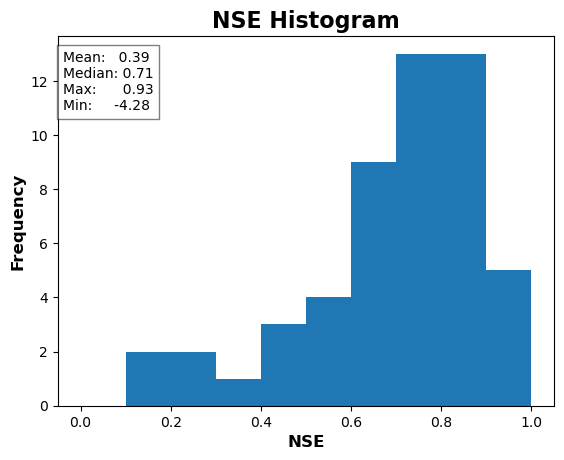

In [24]:
# Plot histogram of NSE

# Export NSE of different basins to a txt
aux= [list(selected_basins_id), list(np.round(loss_testing.flatten().cpu().detach().numpy(),2))]
df_NSE= pd.DataFrame(list(zip(*aux)), columns=['basin_id', 'NSE_LSTM_NonSense'])
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(save_folder+'/NSE_LSTM_NonSense.txt', index=True, header=True)

# Calculate NSE statistics
NSE_array = np.asarray(loss_testing.flatten().cpu().detach().numpy())
NSE_mean = np.mean(NSE_array)
NSE_median = np.median(NSE_array)
NSE_max = np.max(NSE_array)
NSE_min = np.min(NSE_array)

# Plot the histogram
plt.hist(NSE_array, bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.2f" % NSE_mean:>6}\nMedian: {"%.2f" % NSE_median:>0}\nMax: {"%.2f" % NSE_max:>9}\nMin: {"%.2f" % NSE_min:>9}',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel('NSE', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('NSE Histogram', fontsize=16, fontweight='bold')
#plt.savefig(save_folder+'/NSE_Histogram.png', bbox_inches='tight', pad_inches=0)
plt.show()

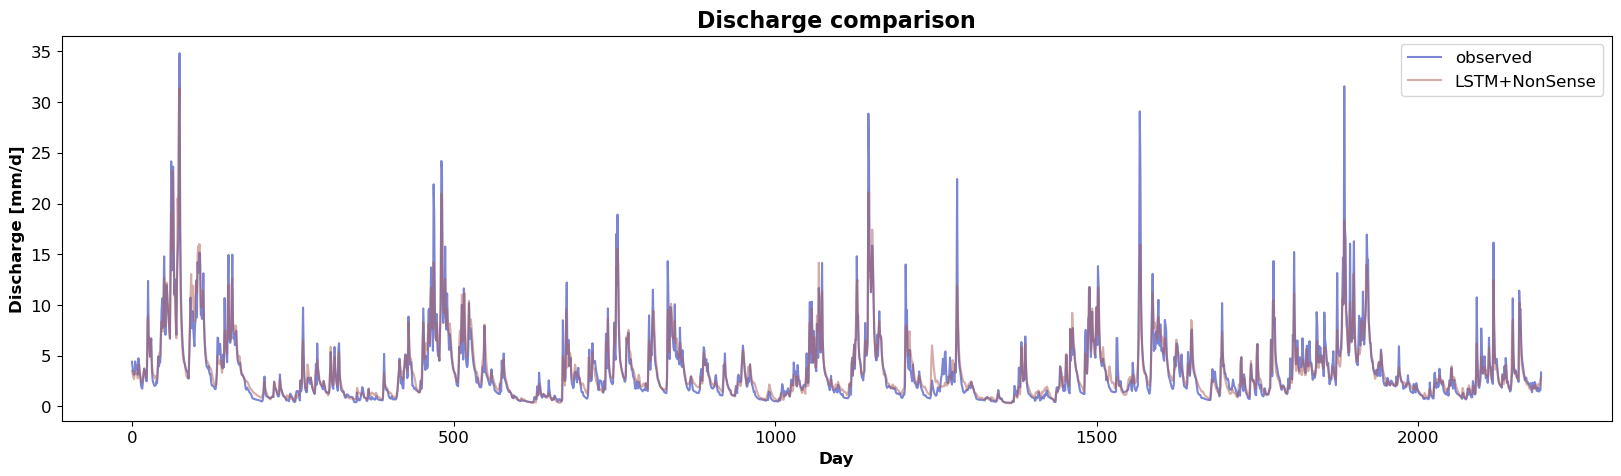

In [25]:
# Plot simulated and observed discharges
basin_to_analyze = 22  # index of the basin. Check the df_NSE variable

sim = sim_q_testing[basin_to_analyze].flatten().cpu().detach().numpy()
obs = obs_q_testing[basin_to_analyze].flatten().cpu().detach().numpy()
plt.plot(obs, label="Observed", color=color_dictionary["Observed"])
plt.plot(sim, label="LSTM+NonSense", alpha=0.5, color=color_dictionary["LSTM+NonSense"])
#np.savetxt(save_folder+"/qsim_LSTM_NonSense.txt", sim)

# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel('Discharge [mm/d]', fontsize=12, fontweight='bold')
plt.title('Discharge comparison', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+'/Model_Comparison.png', bbox_inches='tight', pad_inches=0)
plt.show()

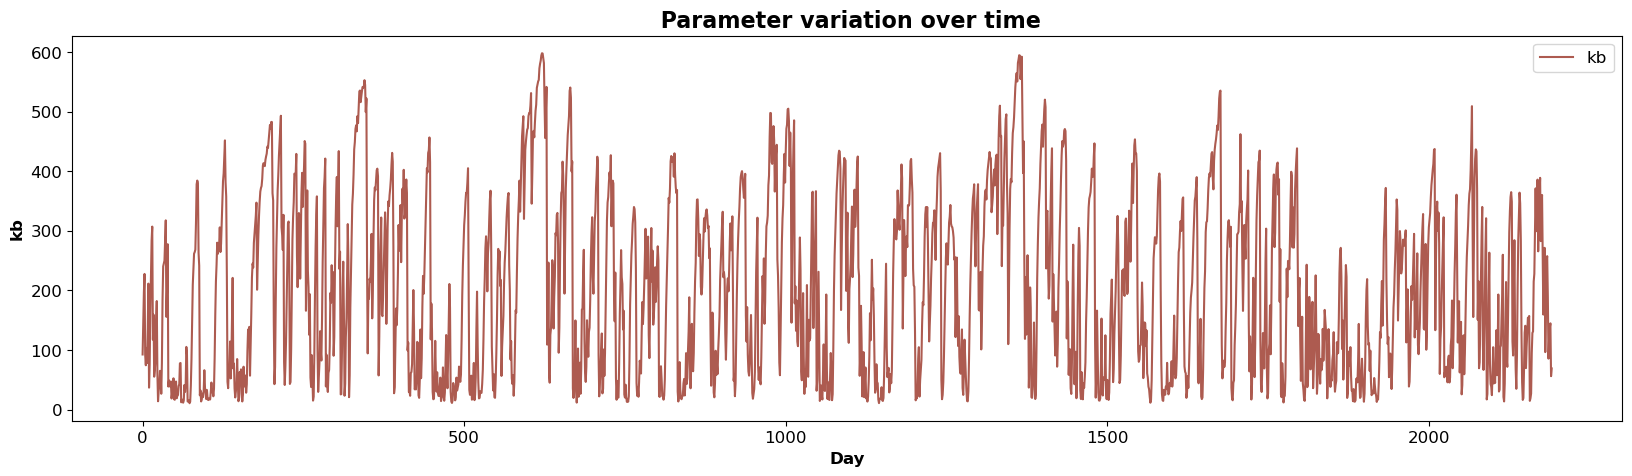

In [26]:
# Plot parameter variation:
param_list = ['dd', 'sumax', 'beta', 'ki', 'kb']
parameter_number= 4 #index of parameter in param_list

# Create plot
param = parameters_testing[basin_to_analyze][:,parameter_number].flatten().cpu().detach().numpy()
plt.plot(param, label= param_list[parameter_number], color=color_dictionary["LSTM+NonSense"])
# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel(param_list[parameter_number], fontsize=12, fontweight='bold')
plt.title(' Parameter variation over time', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+'/Parameter_Variation.png', bbox_inches='tight', pad_inches=0)
plt.show()

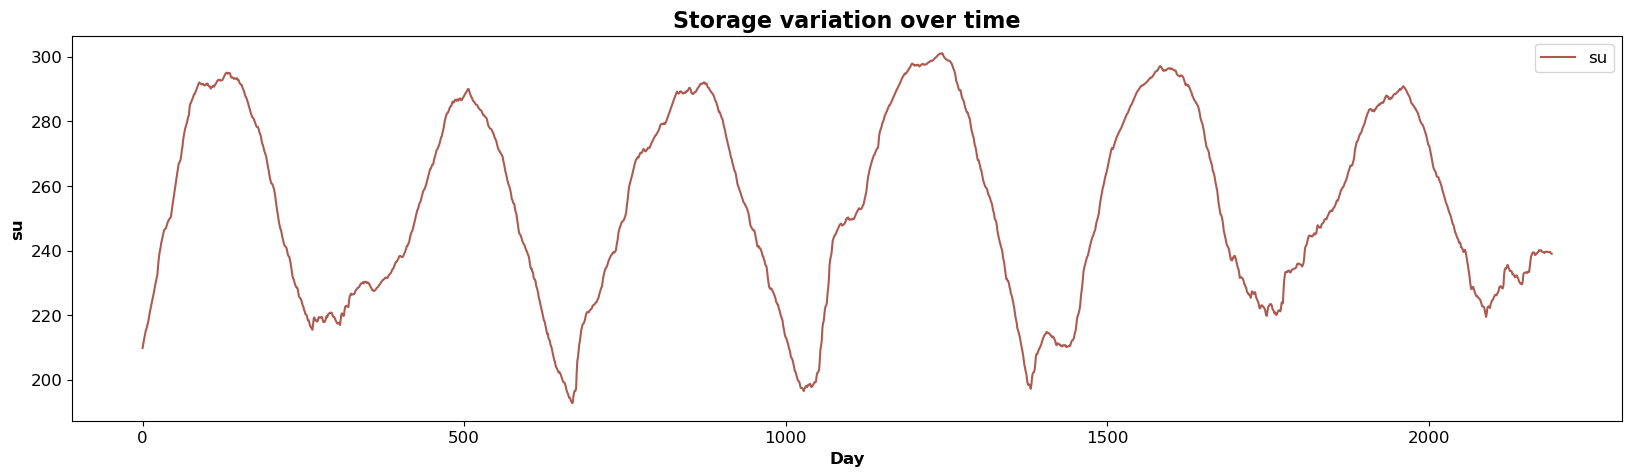

In [27]:
# Plot storage variation
storage_list = ['ss', 'su', 'si','sb']
storage_number= 1 #storage index in storage_list

# Create plot
storage= storages_testing [basin_to_analyze][:,storage_number].flatten().cpu().detach().numpy()
plt.plot(storage, label=storage_list[storage_number], color=color_dictionary["LSTM+NonSense"])
# Format plot
plt.xlabel('Day', fontsize=12, fontweight='bold')
plt.ylabel(storage_list[storage_number], fontsize=12, fontweight='bold')
plt.title('Storage variation over time', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc="upper right",fontsize=12)
#plt.savefig(save_folder+'/Storage_Variation.png', bbox_inches='tight', pad_inches=0)
plt.show()